In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
def load_image(image_path):
    """
    Load an image and convert it to grayscale
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        numpy.ndarray: Grayscale image as 2D array
    """
    # Try to load the image
    if os.path.exists(image_path):
        # Load image using OpenCV (BGR format)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # Try with PIL if OpenCV fails
            img = Image.open(image_path).convert('L')
            img = np.array(img)
    else:
        # Create a simple test pattern if no image is provided
        print(f"Image not found at {image_path}. Creating a test pattern.")
        img = create_test_pattern()
    
    return img.astype(np.float64)

def create_test_pattern(size=256):
    """
    Create a simple test pattern for demonstration
    
    Args:
        size (int): Size of the square image
    
    Returns:
        numpy.ndarray: Test pattern image
    """
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    
    # Create a pattern with multiple frequencies
    pattern = np.sin(10 * np.pi * x) * np.cos(8 * np.pi * y)
    pattern += 0.5 * np.sin(20 * np.pi * x) * np.sin(15 * np.pi * y)
    
    # Normalize to 0-255 range
    pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255
    
    return pattern

In [5]:
def perform_fft(image):
    """
    Perform 2D Fast Fourier Transform on an image
    
    Args:
        image (numpy.ndarray): Input image (2D array)
    
    Returns:
        tuple: (fft_result, fft_magnitude, fft_phase, fft_shifted)
    """
    # Perform 2D FFT
    fft_result = np.fft.fft2(image)
    
    # Shift the zero frequency component to the center
    fft_shifted = np.fft.fftshift(fft_result)
    
    # Calculate magnitude and phase
    fft_magnitude = np.abs(fft_shifted)
    fft_phase = np.angle(fft_shifted)
    
    return fft_result, fft_magnitude, fft_phase, fft_shifted

def perform_ifft(fft_result):
    """
    Perform inverse 2D Fast Fourier Transform
    
    Args:
        fft_result (numpy.ndarray): FFT result to invert
    
    Returns:
        numpy.ndarray: Reconstructed image
    """
    # Perform inverse FFT
    reconstructed = np.fft.ifft2(fft_result)
    
    # Take the real part and ensure it's the right data type
    reconstructed = np.real(reconstructed)
    
    return reconstructed

In [6]:
def plot_fft_results(original_image, fft_magnitude, fft_phase, reconstructed_image):
    """
    Plot the original image, FFT results, and reconstructed image
    
    Args:
        original_image (numpy.ndarray): Original input image
        fft_magnitude (numpy.ndarray): Magnitude of FFT
        fft_phase (numpy.ndarray): Phase of FFT
        reconstructed_image (numpy.ndarray): Reconstructed image from inverse FFT
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original image
    axes[0, 0].imshow(original_image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # FFT Magnitude (log scale for better visualization)
    axes[0, 1].imshow(np.log(fft_magnitude + 1), cmap='viridis')
    axes[0, 1].set_title('FFT Magnitude (Log Scale)')
    axes[0, 1].axis('off')
    
    # FFT Phase
    axes[1, 0].imshow(fft_phase, cmap='hsv')
    axes[1, 0].set_title('FFT Phase')
    axes[1, 0].axis('off')
    
    # Reconstructed image
    axes[1, 1].imshow(reconstructed_image, cmap='gray')
    axes[1, 1].set_title('Reconstructed Image (IFFT)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_frequency_content(fft_magnitude):
    """
    Analyze the frequency content of the image
    
    Args:
        fft_magnitude (numpy.ndarray): Magnitude of FFT
    """
    # Find the center of the FFT
    center_y, center_x = np.array(fft_magnitude.shape) // 2
    
    # Create frequency maps
    y_freq = np.fft.fftfreq(fft_magnitude.shape[0])
    x_freq = np.fft.fftfreq(fft_magnitude.shape[1])
    
    # Calculate radial frequency profile
    y, x = np.ogrid[:fft_magnitude.shape[0], :fft_magnitude.shape[1]]
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2).astype(int)
    
    # Calculate average magnitude for each radius
    r_max = min(center_x, center_y)
    radial_profile = np.zeros(r_max)
    
    for radius in range(r_max):
        mask = (r == radius)
        if np.any(mask):
            radial_profile[radius] = np.mean(fft_magnitude[mask])
    
    # Plot radial frequency profile
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(radial_profile)
    plt.xlabel('Spatial Frequency (pixels)')
    plt.ylabel('Average Magnitude')
    plt.title('Radial Frequency Profile')
    plt.grid(True)
    
    # Plot 2D frequency spectrum
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(fft_magnitude + 1), cmap='viridis', extent=[x_freq.min(), x_freq.max(), y_freq.min(), y_freq.max()])
    plt.xlabel('Frequency X')
    plt.ylabel('Frequency Y')
    plt.title('2D Frequency Spectrum')
    plt.colorbar(label='Log Magnitude')
    
    plt.tight_layout()
    plt.show()

Loading image...
Image shape: (3036, 4024)
Image data type: float64
Image value range: 0.00 to 243.00

Performing Fourier Transform...
FFT result shape: (3036, 4024)
FFT result data type: complex128

Performing Inverse Fourier Transform...
FFT result shape: (3036, 4024)
FFT result data type: complex128

Performing Inverse Fourier Transform...
Reconstruction error (should be close to 0): 0.0000000000
Reconstruction error (should be close to 0): 0.0000000000


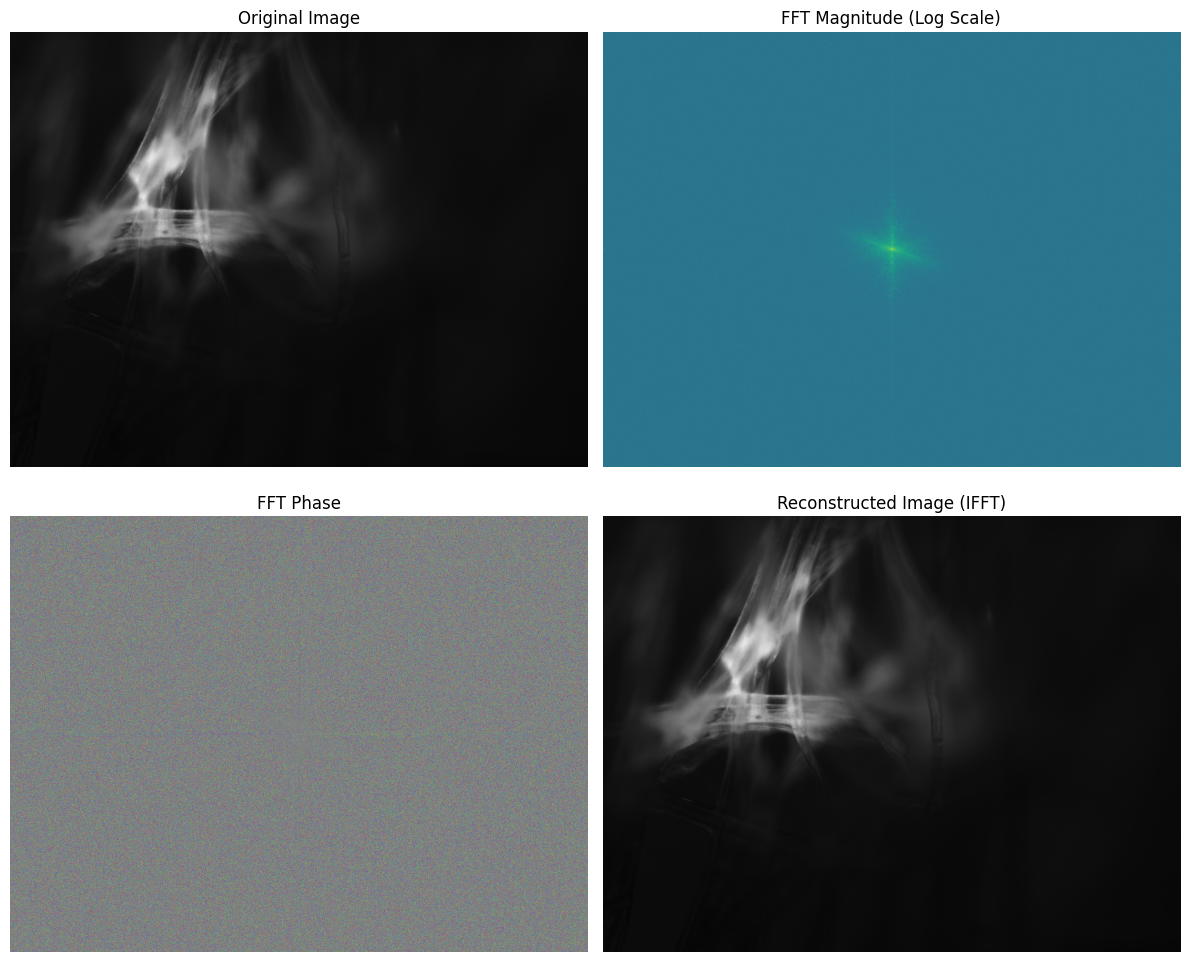

In [7]:
# Main execution code
# You can modify the image_path to use your own image
image_path = r"C:\Users\workh\OneDrive\桌面\Research Lab\第一组图\未处理\Pic_20250829132635393.tiff"  # Change this to your image path

# Load the image
print("Loading image...")
image = load_image(image_path)
print(f"Image shape: {image.shape}")
print(f"Image data type: {image.dtype}")
print(f"Image value range: {image.min():.2f} to {image.max():.2f}")

# Perform FFT
print("\nPerforming Fourier Transform...")
fft_result, fft_magnitude, fft_phase, fft_shifted = perform_fft(image)

print(f"FFT result shape: {fft_result.shape}")
print(f"FFT result data type: {fft_result.dtype}")

# Perform inverse FFT to verify the process
print("\nPerforming Inverse Fourier Transform...")
reconstructed = perform_ifft(fft_result)

# Check reconstruction quality
reconstruction_error = np.mean(np.abs(image - reconstructed))
print(f"Reconstruction error (should be close to 0): {reconstruction_error:.10f}")

# Plot all results
plot_fft_results(image, fft_magnitude, fft_phase, reconstructed)

In [ ]:
# Analyze frequency content
print("Analyzing frequency content...")
analyze_frequency_content(fft_magnitude)

In [ ]:
# Example: Low-pass filtering in frequency domain
def apply_lowpass_filter(fft_shifted, cutoff_radius):
    """
    Apply a low-pass filter in the frequency domain
    
    Args:
        fft_shifted (numpy.ndarray): FFT result (shifted)
        cutoff_radius (int): Radius for the low-pass filter
    
    Returns:
        numpy.ndarray: Filtered image
    """
    # Create a circular mask
    rows, cols = fft_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    
    # Create coordinate matrices
    y, x = np.ogrid[:rows, :cols]
    
    # Create circular mask
    mask = (x - center_col)**2 + (y - center_row)**2 <= cutoff_radius**2
    
    # Apply the mask
    fft_filtered = fft_shifted.copy()
    fft_filtered[~mask] = 0
    
    # Shift back and perform inverse FFT
    fft_unshifted = np.fft.ifftshift(fft_filtered)
    filtered_image = np.real(np.fft.ifft2(fft_unshifted))
    
    return filtered_image, mask

# Apply low-pass filter with different cutoff frequencies
cutoff_radii = [20, 50, 100]

plt.figure(figsize=(15, 10))

for i, cutoff in enumerate(cutoff_radii):
    filtered_image, mask = apply_lowpass_filter(fft_shifted, cutoff)
    
    plt.subplot(2, len(cutoff_radii), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Filter Mask (r={cutoff})')
    plt.axis('off')
    
    plt.subplot(2, len(cutoff_radii), i + 1 + len(cutoff_radii))
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'Filtered Image (r={cutoff})')
    plt.axis('off')

plt.tight_layout()
plt.show()